In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("loan_predication.csv")

df = df.drop(columns=['Loan_ID'])
# Check missing values
print("Missing values per column:\n")
print(df.isnull().sum())

# Encode target with LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['Loan_Status'])
print("Classes mapping:", le.classes_)
X = df.drop(columns=['Loan_Status'])

# Apply LabelEncoder on all non-numeric columns
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Handle missing values (median for numeric, mode for categorical)
X = X.fillna(X.median(numeric_only=True))
X = X.fillna(X.mode().iloc[0])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

Missing values per column:

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Classes mapping: ['N' 'Y']


((429, 11), (185, 11))

In [3]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [4]:
# Build SHAP explainer and compute values
shap.initjs()
explainer = shap.TreeExplainer(rf_model)
shap_exp = explainer(X_test)

# Handle multiclass (select positive class = 1)
shap_vals = shap_exp.values
if shap_vals.ndim == 3:
    shap_vals = shap_vals[:, :, 1]

# Robust expected value for binary/multiclass
exp_value = explainer.expected_value
if isinstance(exp_value, (list, tuple, np.ndarray)):
    exp_value = exp_value[1]

In [5]:
# Calculate global feature importance (mean absolute SHAP)
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP|': mean_abs_shap
})
feature_importance['Percentage'] = 100 * feature_importance['Mean |SHAP|'] / feature_importance['Mean |SHAP|'].sum()
feature_importance = feature_importance.sort_values(by='Mean |SHAP|', ascending=False).reset_index(drop=True)
print('## Global Feature Importance (Numeric Values):')
display(feature_importance)

## Global Feature Importance (Numeric Values):


,Feature,Mean |SHAP|,Percentage
0,Credit_History,0.160446,43.730663
1,Property_Area,0.040504,11.039676
2,ApplicantIncome,0.031107,8.478320
3,LoanAmount,0.030088,8.200775
4,CoapplicantIncome,0.026706,7.278916
5,Married,0.021680,5.908994
6,Loan_Amount_Term,0.017710,4.826958
7,Dependents,0.016911,4.609241
8,Education,0.008569,2.335529
9,Self_Employed,0.007123,1.941492


## Global Feature Importance (Summary Plot):


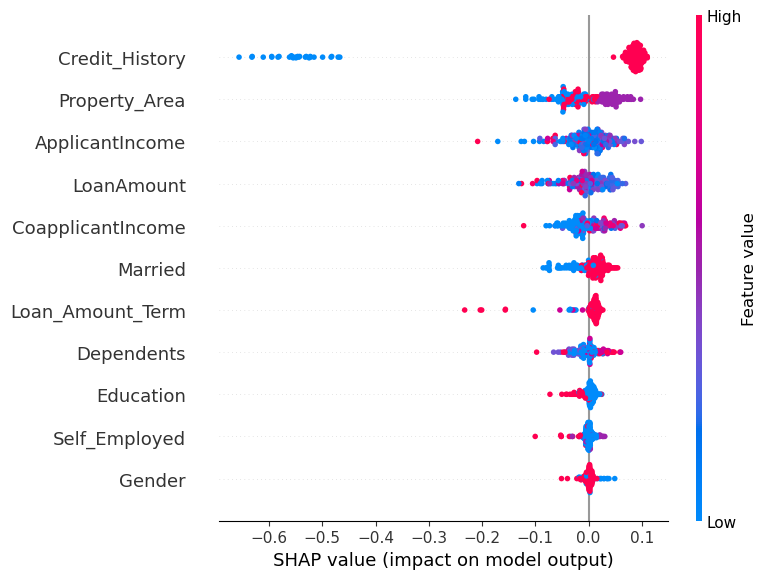

In [19]:
# Global summary plot for all features
print('## Global Feature Importance (Summary Plot):')
shap.summary_plot(shap_vals, X_test)

In [6]:
# SVM
from sklearn.svm import SVC
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [15]:
# Build SHAP explainer and compute values
shap.initjs()
#explainer = shap.KernelExplainer(svm_model.predict_proba, X_train)

#explainer = shap.TreeExplainer(svm_model)
shap_explainer = shap.KernelExplainer(svm_model.predict_proba, X_test)
shap_values = shap_explainer.shap_values(X_test)




Using 185 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/185 [00:00<?, ?it/s]

In [16]:
# Handle multiclass (select positive class = 1)
#shap_vals = shap_exp.values
if shap_values.ndim == 3:
    shap_values = shap_values[:, :, 1]

# Robust expected value for binary/multiclass
exp_value = shap_explainer.expected_value
if isinstance(exp_value, (list, tuple, np.ndarray)):
    exp_value = exp_value[1]

In [17]:
# Calculate global feature importance (mean absolute SHAP)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP|': mean_abs_shap
})
feature_importance['Percentage'] = 100 * feature_importance['Mean |SHAP|'] / feature_importance['Mean |SHAP|'].sum()
feature_importance = feature_importance.sort_values(by='Mean |SHAP|', ascending=False).reset_index(drop=True)
print('## Global Feature Importance (Numeric Values):')
display(feature_importance)

## Global Feature Importance (Numeric Values):


,Feature,Mean |SHAP|,Percentage
0,ApplicantIncome,0.002518,58.075217
1,CoapplicantIncome,0.001814,41.834084
2,LoanAmount,0.000004,0.090699
3,Dependents,0.000000,0.000000
4,Married,0.000000,0.000000
5,Gender,0.000000,0.000000
6,Self_Employed,0.000000,0.000000
7,Education,0.000000,0.000000
8,Loan_Amount_Term,0.000000,0.000000
9,Credit_History,0.000000,0.000000


## Global Feature Importance (Summary Plot):


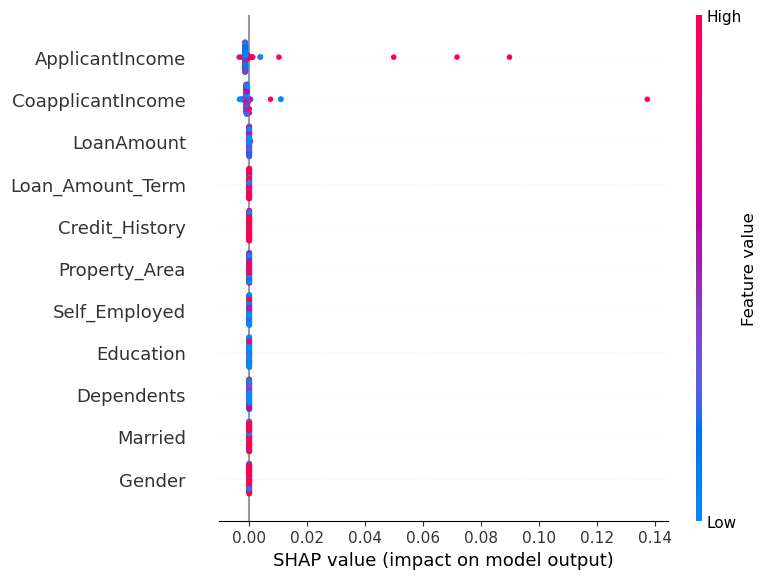

In [18]:
# Global summary plot for all features
print('## Global Feature Importance (Summary Plot):')
shap.summary_plot(shap_values, X_test)